In [39]:
pip install imbalanced-learn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [40]:
pip install lightgbm xgboost catboost


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import warnings
from imblearn.over_sampling import SMOTE
from collections import Counter
warnings.filterwarnings('ignore')

In [42]:
df = pd.read_csv('loan_approval_dataset.csv')

In [43]:
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [44]:
print(f"Total samples: {len(df)}")
print(f"Features: {df.shape[1]-1}")

Total samples: 4269
Features: 12


In [45]:
df.columns = df.columns.str.strip()  # removes spaces

In [46]:
print(df['loan_status'].value_counts(normalize=True))

loan_status
Approved    0.62216
Rejected    0.37784
Name: proportion, dtype: float64


In [47]:
class_counts = df['loan_status'].value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"Class imbalance ratio: {imbalance_ratio:.2f}")
if imbalance_ratio > 3:
    print("⚠️  High class imbalance detected - using stratified sampling")

Class imbalance ratio: 1.65


In [48]:
print(df['loan_status'].value_counts(normalize=True))

loan_status
Approved    0.62216
Rejected    0.37784
Name: proportion, dtype: float64


In [49]:
df_clean = df.drop('loan_id', axis=1).copy()

In [50]:
le_education = LabelEncoder()
le_employed = LabelEncoder()
le_target = LabelEncoder()

df_clean['education_encoded'] = le_education.fit_transform(df_clean['education'])
df_clean['self_employed_encoded'] = le_employed.fit_transform(df_clean['self_employed'])
df_clean['loan_status_encoded'] = le_target.fit_transform(df_clean['loan_status'])

In [51]:
df_clean

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,education_encoded,self_employed_encoded,loan_status_encoded
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved,0,0,0
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected,1,1,1
2,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected,0,0,1
3,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected,0,0,1
4,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264,5,Graduate,Yes,1000000,2300000,12,317,2800000,500000,3300000,800000,Rejected,0,1,1
4265,0,Not Graduate,Yes,3300000,11300000,20,559,4200000,2900000,11000000,1900000,Approved,1,1,0
4266,2,Not Graduate,No,6500000,23900000,18,457,1200000,12400000,18100000,7300000,Rejected,1,0,1
4267,1,Not Graduate,No,4100000,12800000,8,780,8200000,700000,14100000,5800000,Approved,1,0,0


In [52]:
essential_features = ['no_of_dependents', 'education_encoded', 'self_employed_encoded', 
                     'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value',
                     'bank_asset_value', 'luxury_assets_value']

In [53]:
X = df_clean[essential_features]
y = df_clean['loan_status_encoded']

In [54]:
if len(essential_features) > len(df_clean) // 10:  # Too many features relative to samples
    print("⚠️  Too many features relative to samples - applying feature selection")
    selector = SelectKBest(f_classif, k=min(5, len(essential_features)//2))
    X_selected = selector.fit_transform(X, y)
    selected_features = [essential_features[i] for i in selector.get_support(indices=True)]
    print(f"Reduced to {len(selected_features)} features: {selected_features}")
    X = pd.DataFrame(X_selected, columns=selected_features)

In [55]:
# VERY CONSERVATIVE train-test split for small datasets
if len(df_clean) < 100:
    test_size = 0.15  # Keep more data for training
    print(f"Small dataset: Using {test_size*100}% test split")
else:
    test_size = 0.2
    print(f"Using {test_size*100}% test split")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=y
)

print(f"Training samples before SMOTE: {len(X_train)}, Test samples: {len(X_test)}")

Using 20.0% test split
Training samples before SMOTE: 3415, Test samples: 854


In [56]:
# Apply SMOTE to balance the training data ONLY
print("\nApplying SMOTE to balance training data...")
print("Original training class distribution:", Counter(y_train))

# Configure SMOTE based on dataset size
if len(X_train) < 100:
    # For very small datasets, use fewer neighbors
    k_neighbors = min(3, len(y_train[y_train == y_train.value_counts().idxmin()]) - 1)
    print(f"Small dataset: Using k_neighbors={k_neighbors}")
else:
    k_neighbors = 5  # Default

smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Training samples after SMOTE: {len(X_train_balanced)}")
print("Balanced training class distribution:", Counter(y_train_balanced))

# Update the training data variables
X_train = X_train_balanced
y_train = y_train_balanced


Applying SMOTE to balance training data...
Original training class distribution: Counter({0: 2125, 1: 1290})
Training samples after SMOTE: 4250
Balanced training class distribution: Counter({1: 2125, 0: 2125})


In [57]:
# Add noise to prevent overfitting (data augmentation technique)
def add_controlled_noise(X_train, noise_level=0.01):
    """Add small amount of noise to numerical features to prevent overfitting"""
    X_noisy = X_train.copy()
    numerical_cols = X_train.select_dtypes(include=[np.number]).columns
    
    for col in numerical_cols:
        noise = np.random.normal(0, X_train[col].std() * noise_level, size=len(X_train))
        X_noisy[col] = X_train[col] + noise
    
    return X_noisy

if len(X_train) < 100:
    print("Adding controlled noise to prevent overfitting...")
    X_train_noisy = add_controlled_noise(X_train, noise_level=0.005)  # Very small noise
else:
    X_train_noisy = X_train.copy()

In [58]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_noisy)
X_test_scaled = scaler.transform(X_test)

In [59]:
models = {
    'LogisticRegression': LogisticRegression(
        C=0.01,  # Strong regularization
        penalty='elasticnet',
        l1_ratio=0.5,  # Mix of L1 and L2
        solver='saga',
        max_iter=1000,
        random_state=42
    ),
    
    'LightGBM_Conservative': lgb.LGBMClassifier(
        objective='binary',
        boosting_type='gbdt',
        num_leaves=5,  # VERY small tree
        learning_rate=0.005,  # VERY slow learning
        feature_fraction=0.4,  # Use only 40% of features
        bagging_fraction=0.5,  # Use only 50% of data
        bagging_freq=1,
        min_data_in_leaf=max(5, len(X_train)//20),  # Adaptive minimum samples
        lambda_l1=10.0,  # Very strong L1
        lambda_l2=10.0,  # Very strong L2
        max_depth=3,  # Very shallow
        n_estimators=50,  # Few trees
        verbose=-1,
        random_state=42,
        early_stopping_rounds=10
    ),
    
    'XGBoost_Conservative': xgb.XGBClassifier(
        objective='binary:logistic',
        learning_rate=0.005,  # VERY slow
        max_depth=2,  # Very shallow
        min_child_weight=max(5, len(X_train)//20),  # Adaptive
        subsample=0.5,  # Use only 50% of samples
        colsample_bytree=0.4,  # Use only 40% of features
        reg_alpha=10.0,  # Very strong L1
        reg_lambda=10.0,  # Very strong L2
        gamma=1.0,  # High minimum split loss
        n_estimators=50,  # Few trees
        random_state=42,
        early_stopping_rounds=10,
        eval_metric='logloss'
    ),
    
    'CatBoost_Conservative': CatBoostClassifier(
        iterations=50,  # Very few iterations
        learning_rate=0.005,  # VERY slow
        depth=2,  # Very shallow
        l2_leaf_reg=50.0,  # Very strong regularization
        bootstrap_type='Bernoulli',
        subsample=0.5,  # Use only 50% of data
        rsm=0.4,  # Use only 40% of features
        border_count=16,  # Reduce complexity
        random_seed=42,
        verbose=False,
        early_stopping_rounds=10,
        use_best_model=True
    )
}


In [60]:
if len(X_train) < 50:
    cv_folds = 3  # Few folds for very small datasets
    print(f"Very small dataset: Using {cv_folds}-fold CV")
elif len(X_train) < 100:
    cv_folds = 5
    print(f"Small dataset: Using {cv_folds}-fold CV")
else:
    cv_folds = min(10, len(X_train)//50)  # Adjust based on balanced size
    print(f"Using {cv_folds}-fold CV")

Using 10-fold CV


In [61]:
results = {}
print("\nTraining anti-overfitting models...")

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # ---- Final training with early stopping (tree-based models) ----
    if 'Conservative' in name and len(X_train) > 20:
        # Validation split for early stopping
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_noisy, y_train, test_size=0.2, random_state=42, stratify=y_train
        )
        
        if 'LightGBM' in name:
            model.fit(
                X_tr, y_tr, 
                eval_set=[(X_val, y_val)],
                callbacks=[lgb.early_stopping(10), lgb.log_evaluation(0)]
            )
        elif 'XGBoost' in name:
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
        elif 'CatBoost' in name:
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
    else:
        # LogisticRegression or small dataset → no early stopping
        if name == 'LogisticRegression':
            model.fit(X_train_scaled, y_train)
        else:
            model.fit(X_train_noisy, y_train)
    
    # ---- Predictions ----
    if name == 'LogisticRegression':
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        train_pred_proba = model.predict_proba(X_train_scaled)[:, 1]
    else:
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        train_pred_proba = model.predict_proba(X_train_noisy)[:, 1]
    
    # ---- Metrics ----
    test_auc = roc_auc_score(y_test, y_pred_proba)
    train_auc = roc_auc_score(y_train, train_pred_proba)
    
    # ---- Cross-validation (disable early stopping here) ----
    if name == 'LogisticRegression':
        cv_scores = cross_val_score(
            LogisticRegression(max_iter=1000, solver="lbfgs"), 
            X_train_scaled, y_train, 
            cv=cv_folds, scoring='roc_auc'
        )
    elif 'LightGBM' in name:
        cv_scores = cross_val_score(
            lgb.LGBMClassifier(n_estimators=200),  # no early stopping
            X_train_noisy, y_train, 
            cv=cv_folds, scoring='roc_auc'
        )
    elif 'XGBoost' in name:
        cv_scores = cross_val_score(
            xgb.XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric="auc"), 
            X_train_noisy, y_train, 
            cv=cv_folds, scoring='roc_auc'
        )
    elif 'CatBoost' in name:
        cv_scores = cross_val_score(
            CatBoostClassifier(iterations=200, verbose=False), 
            X_train_noisy, y_train, 
            cv=cv_folds, scoring='roc_auc'
        )
    else:
        cv_scores = cross_val_score(
            model, X_train_noisy, y_train, 
            cv=cv_folds, scoring='roc_auc'
        )
    
    # ---- Store results ----
    results[name] = {
        'model': model,
        'test_auc': test_auc,
        'train_auc': train_auc,
        'auc_gap': train_auc - test_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"Train AUC: {train_auc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"AUC Gap: {train_auc - test_auc:.4f}")
    print(f"CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")



Training anti-overfitting models...

Training LogisticRegression...
Train AUC: 0.9645
Test AUC: 0.9725
AUC Gap: -0.0080
CV Score: 0.9697 (+/- 0.0184)

Training LightGBM_Conservative...
Training until validation scores don't improve for 10 rounds


Did not meet early stopping. Best iteration is:
[50]	valid_0's binary_logloss: 0.662155
Train AUC: 0.9932
Test AUC: 0.9885
AUC Gap: 0.0047
CV Score: 0.9989 (+/- 0.0020)

Training XGBoost_Conservative...
Train AUC: 0.9752
Test AUC: 0.9796
AUC Gap: -0.0044
CV Score: 0.9988 (+/- 0.0031)

Training CatBoost_Conservative...
Train AUC: 0.9898
Test AUC: 0.9868
AUC Gap: 0.0031
CV Score: 0.9986 (+/- 0.0023)


In [62]:
# Detailed evaluation for each model
for name, result in results.items():
    print(f"\n{name} Detailed Results:")
    print("-" * 40)
    
    # Ensure predictions & y_test are in the same format (numeric)
    preds = result['predictions']
    true_labels = y_test
    
    print("Classification Report:")
    print(classification_report(
        true_labels, preds, 
        target_names=[str(cls) for cls in le_target.classes_]
    ))
    
    # Feature importance for tree-based models
    model = result['model']
    
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\nTop 10 Important Features (Tree-based):")
        print(feature_importance.head(10).to_string(index=False))
    
    # Coefficients for Logistic Regression
    elif hasattr(model, 'coef_'):
        coefs = model.coef_[0]
        coef_df = pd.DataFrame({
            'feature': X_train.columns,
            'coefficient': coefs,
            'abs_val': np.abs(coefs)
        }).sort_values('abs_val', ascending=False)
        
        print("\nTop 10 Influential Features (Logistic Regression):")
        print(coef_df.head(10)[['feature', 'coefficient']].to_string(index=False))



LogisticRegression Detailed Results:
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

    Approved       0.99      0.94      0.96       531
    Rejected       0.91      0.98      0.94       323

    accuracy                           0.95       854
   macro avg       0.95      0.96      0.95       854
weighted avg       0.96      0.95      0.95       854


Top 10 Influential Features (Logistic Regression):
                 feature  coefficient
             cibil_score    -3.117914
               loan_term     0.315813
   self_employed_encoded    -0.037372
       education_encoded     0.000000
        no_of_dependents     0.000000
             loan_amount     0.000000
            income_annum     0.000000
residential_assets_value     0.000000
 commercial_assets_value     0.000000
        bank_asset_value     0.000000

LightGBM_Conservative Detailed Results:
----------------------------------------
Classification Repo

In [63]:
overfitting_detected = False

for name, result in results.items():
    print(f"\n{name}:")
    print(f"  Train AUC: {result['train_auc']:.4f}")
    print(f"  Test AUC: {result['test_auc']:.4f}")
    print(f"  AUC Gap: {result['auc_gap']:.4f}")
    print(f"  CV Std: {result['cv_std']:.4f}")
    
    #  Overfitting detection logic
    if result['auc_gap'] > 0.05:
        print(f"  🔴 OVERFITTING DETECTED (Gap > 0.05)")
        overfitting_detected = True
    elif result['test_auc'] <= 0.5:
        print(f"  🟡 RANDOM PERFORMANCE")
        overfitting_detected = True
    elif result['cv_std'] > 0.05:
        print(f"  🟡 HIGH VARIANCE (CV Std > 0.05)")
    else:
        print(f"  ✅ HEALTHY MODEL")



LogisticRegression:
  Train AUC: 0.9645
  Test AUC: 0.9725
  AUC Gap: -0.0080
  CV Std: 0.0092
  ✅ HEALTHY MODEL

LightGBM_Conservative:
  Train AUC: 0.9932
  Test AUC: 0.9885
  AUC Gap: 0.0047
  CV Std: 0.0010
  ✅ HEALTHY MODEL

XGBoost_Conservative:
  Train AUC: 0.9752
  Test AUC: 0.9796
  AUC Gap: -0.0044
  CV Std: 0.0015
  ✅ HEALTHY MODEL

CatBoost_Conservative:
  Train AUC: 0.9898
  Test AUC: 0.9868
  AUC Gap: 0.0031
  CV Std: 0.0012
  ✅ HEALTHY MODEL



Model Performance Summary:


,train_auc,test_auc,auc_gap,cv_mean,cv_std
LogisticRegression,0.964464,0.972509,-0.008045,0.969663,0.009211
LightGBM_Conservative,0.993158,0.988494,0.004665,0.998904,0.001019
XGBoost_Conservative,0.975226,0.979637,-0.004411,0.998800,0.001538
CatBoost_Conservative,0.989846,0.986768,0.003079,0.998587,0.001158


<Figure size 1000x600 with 0 Axes>

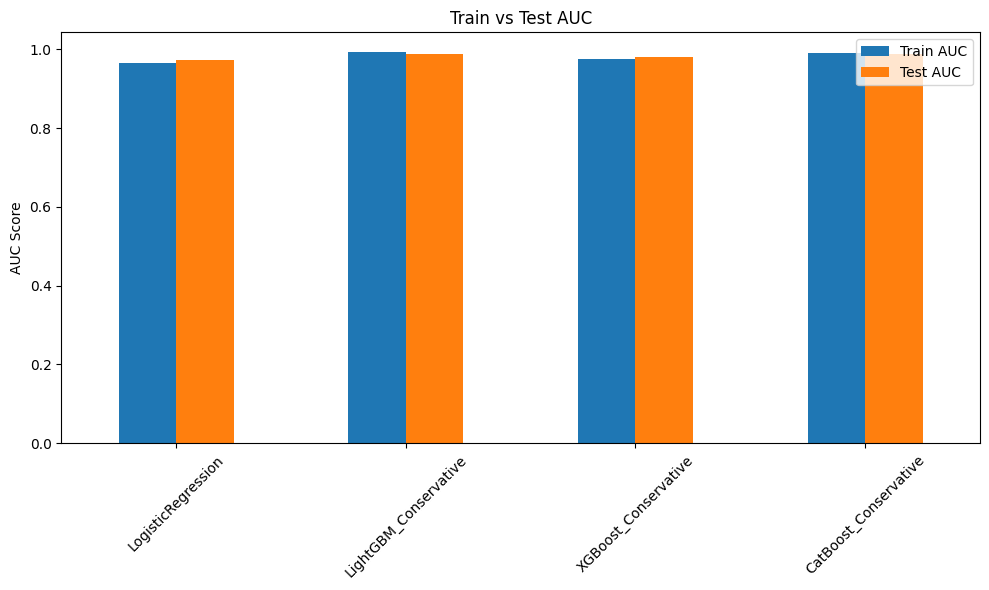

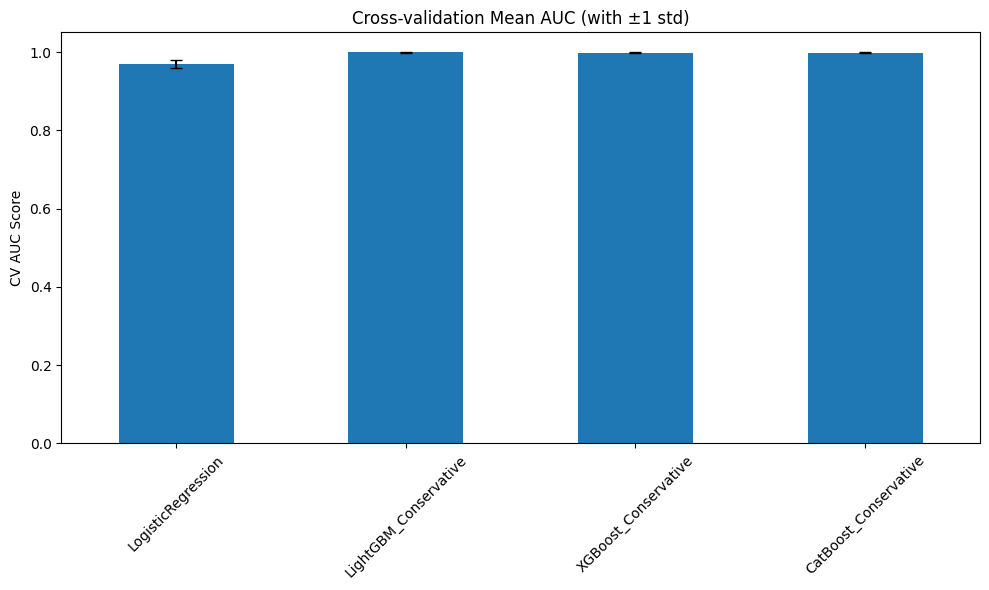

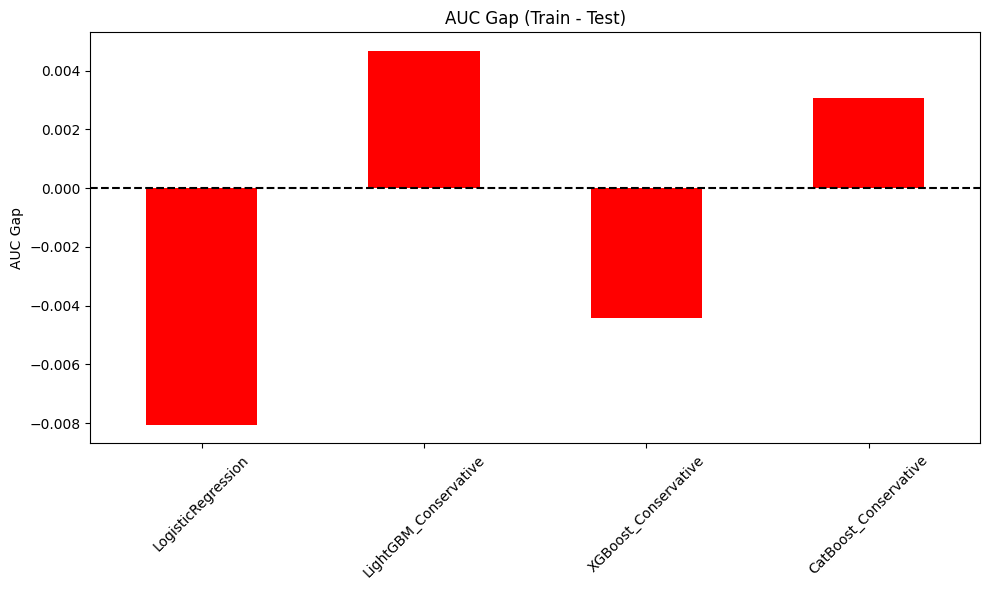

In [64]:
# Convert results dict → DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')

# Show as table
print("\nModel Performance Summary:")
display(results_df[['train_auc', 'test_auc', 'auc_gap', 'cv_mean', 'cv_std']])

# --- Bar chart: Train vs Test AUC ---
plt.figure(figsize=(10, 6))
results_df[['train_auc', 'test_auc']].plot(
    kind='bar', figsize=(10,6), rot=45
)
plt.title("Train vs Test AUC")
plt.ylabel("AUC Score")
plt.legend(["Train AUC", "Test AUC"])
plt.tight_layout()
plt.show()

# --- Bar chart: Cross-validation mean AUC ---
plt.figure(figsize=(10, 6))
results_df['cv_mean'].plot(
    kind='bar', yerr=results_df['cv_std'], capsize=4, rot=45
)
plt.title("Cross-validation Mean AUC (with ±1 std)")
plt.ylabel("CV AUC Score")
plt.tight_layout()
plt.show()

# --- Bar chart: AUC Gap (Overfitting indicator) ---
plt.figure(figsize=(10, 6))
results_df['auc_gap'].plot(kind='bar', color='red', rot=45)
plt.title("AUC Gap (Train - Test)")
plt.ylabel("AUC Gap")
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()



LogisticRegression Detailed Results:
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

    Approved       0.99      0.94      0.96       531
    Rejected       0.91      0.98      0.94       323

    accuracy                           0.95       854
   macro avg       0.95      0.96      0.95       854
weighted avg       0.96      0.95      0.95       854


Confusion Matrix:
[[498  33]
 [  6 317]]


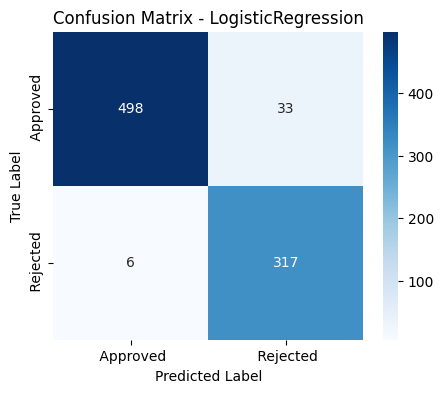


LightGBM_Conservative Detailed Results:
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

    Approved       0.96      0.99      0.97       531
    Rejected       0.98      0.93      0.96       323

    accuracy                           0.97       854
   macro avg       0.97      0.96      0.96       854
weighted avg       0.97      0.97      0.97       854


Confusion Matrix:
[[526   5]
 [ 23 300]]


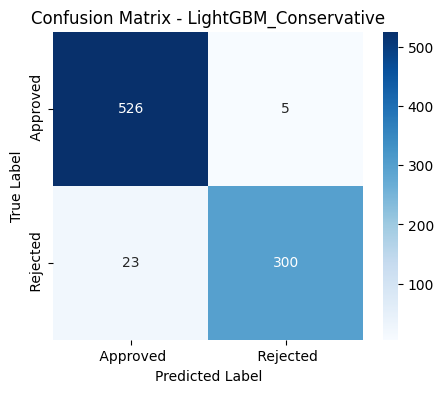


XGBoost_Conservative Detailed Results:
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

    Approved       0.96      0.96      0.96       531
    Rejected       0.93      0.94      0.93       323

    accuracy                           0.95       854
   macro avg       0.95      0.95      0.95       854
weighted avg       0.95      0.95      0.95       854


Confusion Matrix:
[[508  23]
 [ 20 303]]


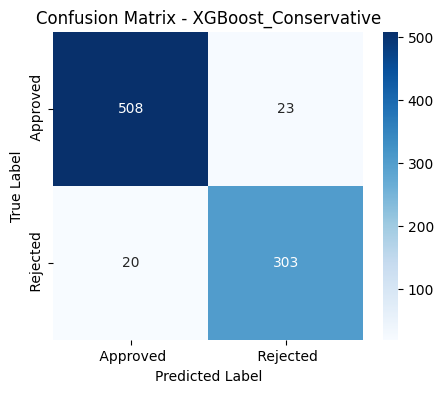


CatBoost_Conservative Detailed Results:
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

    Approved       0.99      0.92      0.95       531
    Rejected       0.88      0.98      0.93       323

    accuracy                           0.94       854
   macro avg       0.93      0.95      0.94       854
weighted avg       0.95      0.94      0.94       854


Confusion Matrix:
[[488  43]
 [  6 317]]


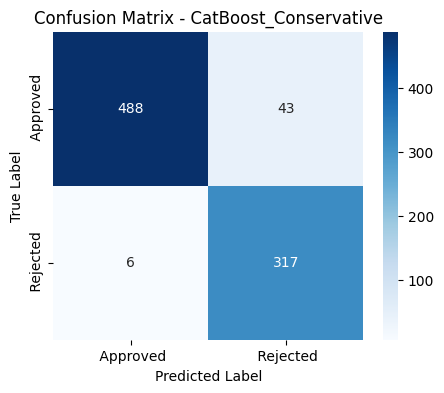

In [65]:
# Detailed evaluation for each model
for name, result in results.items():
    print(f"\n{name} Detailed Results:")
    print("-" * 40)
    
    preds = result['predictions']
    true_labels = y_test
    
    # ---- Classification Report ----
    print("Classification Report:")
    print(classification_report(
        true_labels, preds, 
        target_names=[str(cls) for cls in le_target.classes_]
    ))
    
    # ---- Confusion Matrix ----
    cm = confusion_matrix(true_labels, preds)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot Confusion Matrix (Heatmap)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", 
                xticklabels=le_target.classes_, 
                yticklabels=le_target.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

### Experiment 2

In [66]:
results = {}
print("\nTraining anti-overfitting models...")

for name, model in models.items():
    print(f"\nTraining {name}...")

    # ---- Early stopping for tree-based models ----
    if 'Conservative' in name and len(X_train) > 20:
        # Create a validation split
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_noisy, y_train, test_size=0.2, random_state=42, stratify=y_train
        )

        if 'LightGBM' in name:
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                callbacks=[lgb.early_stopping(10), lgb.log_evaluation(0)]
            )
        elif 'XGBoost' in name:
            # eval_metric must be in the constructor
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
        elif 'CatBoost' in name:
            model.fit(
                X_tr, y_tr,
                eval_set=(X_val, y_val),
                verbose=False
            )
    else:
        # Logistic Regression or very small datasets
        if name == 'LogisticRegression':
            model.fit(X_train_scaled, y_train)
        else:
            model.fit(X_train_noisy, y_train)

    # ---- Predictions ----
    if name == 'LogisticRegression':
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        train_pred_proba = model.predict_proba(X_train_scaled)[:, 1]
    else:
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        train_pred_proba = model.predict_proba(X_train_noisy)[:, 1]

    # ---- Metrics ----
    test_auc = roc_auc_score(y_test, y_pred_proba)
    train_auc = roc_auc_score(y_train, train_pred_proba)

    # ---- Cross-validation (disable early stopping for fair comparison) ----
    if name == 'LogisticRegression':
        cv_model = LogisticRegression(max_iter=1000, solver='lbfgs')
        cv_scores = cross_val_score(cv_model, X_train_scaled, y_train,
                                    cv=cv_folds, scoring='roc_auc')
    elif 'LightGBM' in name:
        cv_model = lgb.LGBMClassifier(n_estimators=200, random_state=42)
        cv_scores = cross_val_score(cv_model, X_train_noisy, y_train,
                                    cv=cv_folds, scoring='roc_auc')
    elif 'XGBoost' in name:
        cv_model = xgb.XGBClassifier(
            n_estimators=200,
            use_label_encoder=False,
            eval_metric='auc',
            random_state=42
        )
        cv_scores = cross_val_score(cv_model, X_train_noisy, y_train,
                                    cv=cv_folds, scoring='roc_auc')
    elif 'CatBoost' in name:
        cv_model = CatBoostClassifier(iterations=200, verbose=False, random_seed=42)
        cv_scores = cross_val_score(cv_model, X_train_noisy, y_train,
                                    cv=cv_folds, scoring='roc_auc')
    else:
        cv_scores = cross_val_score(model, X_train_noisy, y_train,
                                    cv=cv_folds, scoring='roc_auc')

    # ---- Store results ----
    results[name] = {
        'model': model,
        'test_auc': test_auc,
        'train_auc': train_auc,
        'auc_gap': train_auc - test_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"Train AUC: {train_auc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"AUC Gap: {train_auc - test_auc:.4f}")
    print(f"CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")



Training anti-overfitting models...

Training LogisticRegression...


Train AUC: 0.9645
Test AUC: 0.9725
AUC Gap: -0.0080
CV Score: 0.9697 (+/- 0.0184)

Training LightGBM_Conservative...
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's binary_logloss: 0.662155
Train AUC: 0.9932
Test AUC: 0.9885
AUC Gap: 0.0047
CV Score: 0.9989 (+/- 0.0020)

Training XGBoost_Conservative...
Train AUC: 0.9752
Test AUC: 0.9796
AUC Gap: -0.0044
CV Score: 0.9988 (+/- 0.0031)

Training CatBoost_Conservative...
Train AUC: 0.9898
Test AUC: 0.9868
AUC Gap: 0.0031
CV Score: 0.9987 (+/- 0.0021)


In [67]:
# Detailed evaluation for each model
for name, result in results.items():
    print(f"\n{name} Detailed Results:")
    print("-" * 40)
    
    # Ensure predictions & y_test are in the same format (numeric)
    preds = result['predictions']
    true_labels = y_test
    
    print("Classification Report:")
    print(classification_report(
        true_labels, preds, 
        target_names=[str(cls) for cls in le_target.classes_]
    ))
    
    # Feature importance for tree-based models
    model = result['model']
    
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\nTop 10 Important Features (Tree-based):")
        print(feature_importance.head(10).to_string(index=False))
    
    # Coefficients for Logistic Regression
    elif hasattr(model, 'coef_'):
        coefs = model.coef_[0]
        coef_df = pd.DataFrame({
            'feature': X_train.columns,
            'coefficient': coefs,
            'abs_val': np.abs(coefs)
        }).sort_values('abs_val', ascending=False)
        
        print("\nTop 10 Influential Features (Logistic Regression):")
        print(coef_df.head(10)[['feature', 'coefficient']].to_string(index=False))



LogisticRegression Detailed Results:
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

    Approved       0.99      0.94      0.96       531
    Rejected       0.91      0.98      0.94       323

    accuracy                           0.95       854
   macro avg       0.95      0.96      0.95       854
weighted avg       0.96      0.95      0.95       854


Top 10 Influential Features (Logistic Regression):
                 feature  coefficient
             cibil_score    -3.117914
               loan_term     0.315813
   self_employed_encoded    -0.037372
       education_encoded     0.000000
        no_of_dependents     0.000000
             loan_amount     0.000000
            income_annum     0.000000
residential_assets_value     0.000000
 commercial_assets_value     0.000000
        bank_asset_value     0.000000

LightGBM_Conservative Detailed Results:
----------------------------------------
Classification Repo

In [68]:
overfitting_detected = False

for name, result in results.items():
    print(f"\n{name}:")
    print(f"  Train AUC: {result['train_auc']:.4f}")
    print(f"  Test AUC: {result['test_auc']:.4f}")
    print(f"  AUC Gap: {result['auc_gap']:.4f}")
    print(f"  CV Std: {result['cv_std']:.4f}")
    
    #  Overfitting detection logic
    if result['auc_gap'] > 0.05:
        print(f"  🔴 OVERFITTING DETECTED (Gap > 0.05)")
        overfitting_detected = True
    elif result['test_auc'] <= 0.5:
        print(f"  🟡 RANDOM PERFORMANCE")
        overfitting_detected = True
    elif result['cv_std'] > 0.05:
        print(f"  🟡 HIGH VARIANCE (CV Std > 0.05)")
    else:
        print(f"  ✅ HEALTHY MODEL")


LogisticRegression:
  Train AUC: 0.9645
  Test AUC: 0.9725
  AUC Gap: -0.0080
  CV Std: 0.0092
  ✅ HEALTHY MODEL

LightGBM_Conservative:
  Train AUC: 0.9932
  Test AUC: 0.9885
  AUC Gap: 0.0047
  CV Std: 0.0010
  ✅ HEALTHY MODEL

XGBoost_Conservative:
  Train AUC: 0.9752
  Test AUC: 0.9796
  AUC Gap: -0.0044
  CV Std: 0.0015
  ✅ HEALTHY MODEL

CatBoost_Conservative:
  Train AUC: 0.9898
  Test AUC: 0.9868
  AUC Gap: 0.0031
  CV Std: 0.0010
  ✅ HEALTHY MODEL



Model Performance Summary:


,train_auc,test_auc,auc_gap,cv_mean,cv_std
LogisticRegression,0.964464,0.972509,-0.008045,0.969663,0.009211
LightGBM_Conservative,0.993158,0.988494,0.004665,0.998904,0.001019
XGBoost_Conservative,0.975226,0.979637,-0.004411,0.998800,0.001538
CatBoost_Conservative,0.989846,0.986768,0.003079,0.998718,0.001031


<Figure size 1000x600 with 0 Axes>

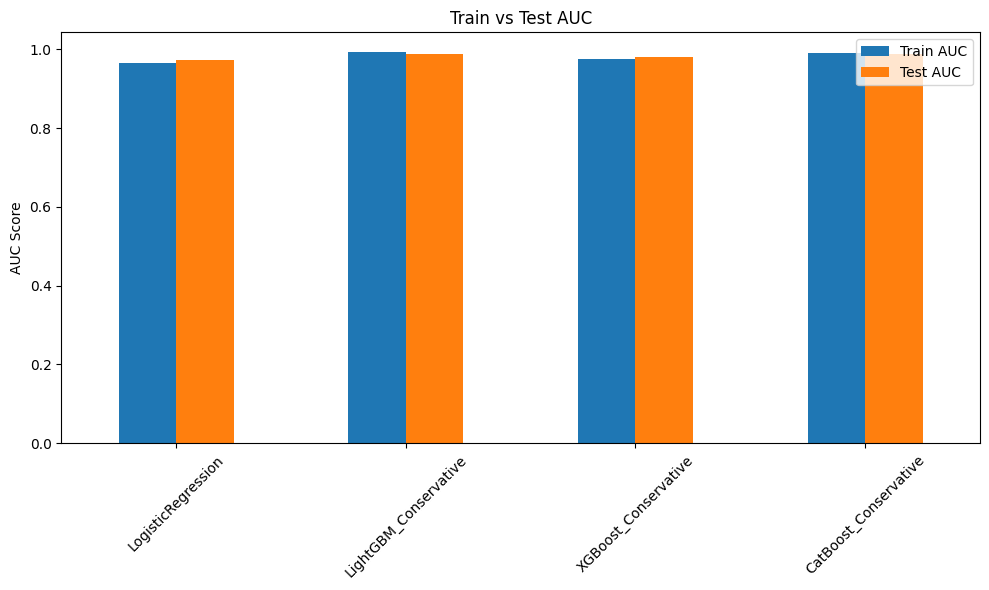

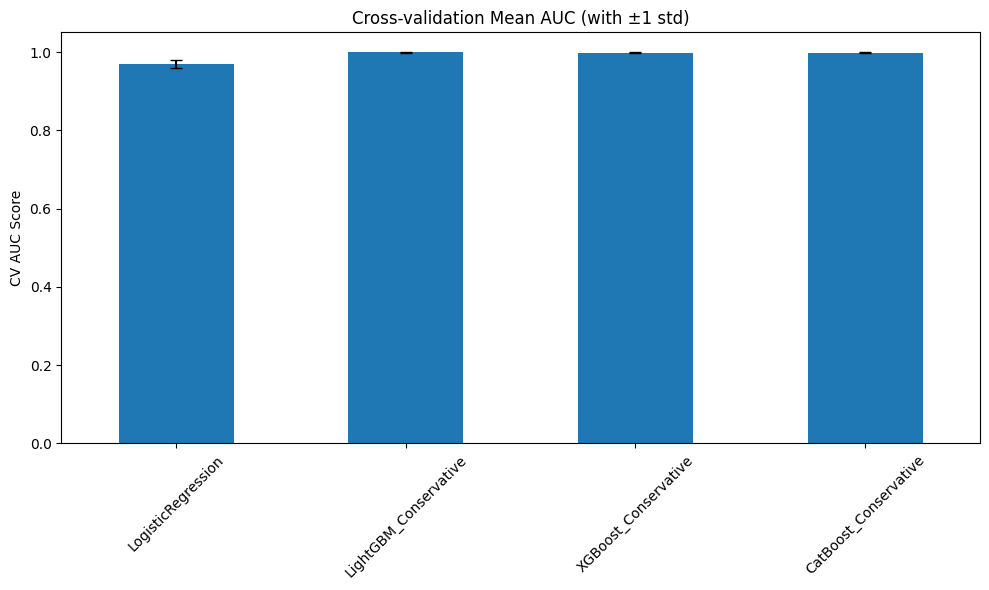

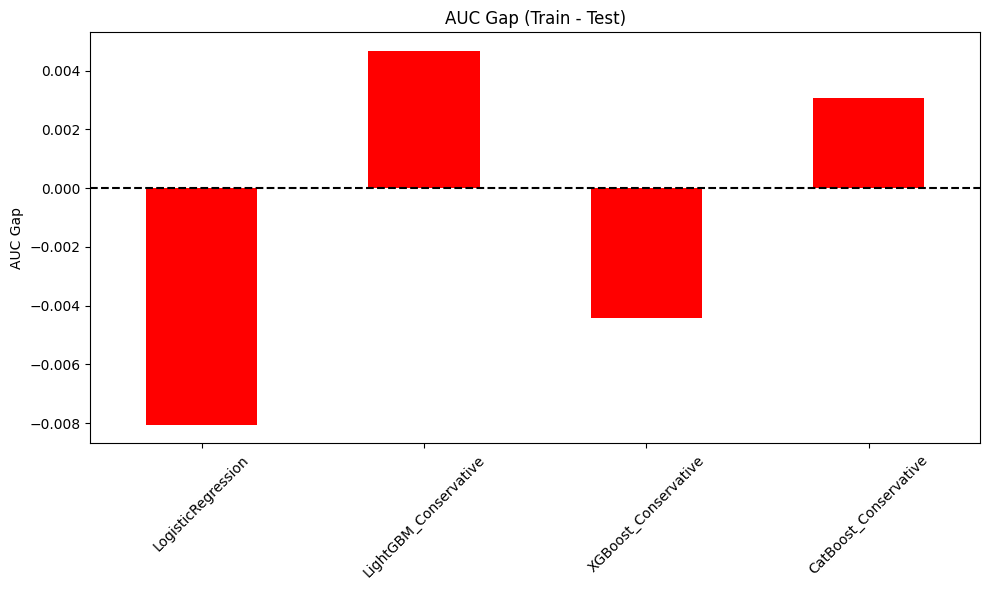

In [69]:
# Convert results dict → DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')

# Show as table
print("\nModel Performance Summary:")
display(results_df[['train_auc', 'test_auc', 'auc_gap', 'cv_mean', 'cv_std']])

# --- Bar chart: Train vs Test AUC ---
plt.figure(figsize=(10, 6))
results_df[['train_auc', 'test_auc']].plot(
    kind='bar', figsize=(10,6), rot=45
)
plt.title("Train vs Test AUC")
plt.ylabel("AUC Score")
plt.legend(["Train AUC", "Test AUC"])
plt.tight_layout()
plt.show()

# --- Bar chart: Cross-validation mean AUC ---
plt.figure(figsize=(10, 6))
results_df['cv_mean'].plot(
    kind='bar', yerr=results_df['cv_std'], capsize=4, rot=45
)
plt.title("Cross-validation Mean AUC (with ±1 std)")
plt.ylabel("CV AUC Score")
plt.tight_layout()
plt.show()

# --- Bar chart: AUC Gap (Overfitting indicator) ---
plt.figure(figsize=(10, 6))
results_df['auc_gap'].plot(kind='bar', color='red', rot=45)
plt.title("AUC Gap (Train - Test)")
plt.ylabel("AUC Gap")
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


LogisticRegression Detailed Results:
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

    Approved       0.99      0.94      0.96       531
    Rejected       0.91      0.98      0.94       323

    accuracy                           0.95       854
   macro avg       0.95      0.96      0.95       854
weighted avg       0.96      0.95      0.95       854


Confusion Matrix:
[[498  33]
 [  6 317]]


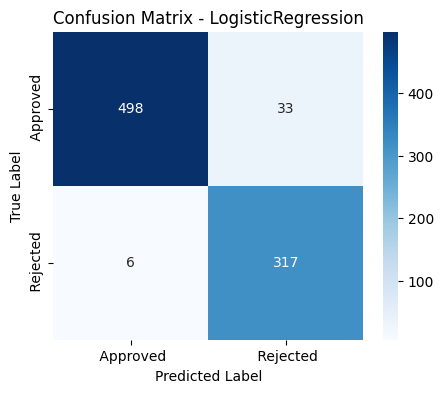


LightGBM_Conservative Detailed Results:
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

    Approved       0.96      0.99      0.97       531
    Rejected       0.98      0.93      0.96       323

    accuracy                           0.97       854
   macro avg       0.97      0.96      0.96       854
weighted avg       0.97      0.97      0.97       854


Confusion Matrix:
[[526   5]
 [ 23 300]]


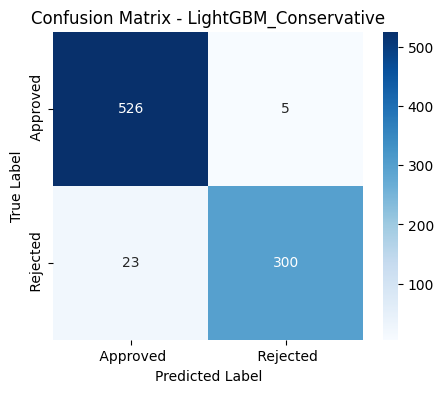


XGBoost_Conservative Detailed Results:
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

    Approved       0.96      0.96      0.96       531
    Rejected       0.93      0.94      0.93       323

    accuracy                           0.95       854
   macro avg       0.95      0.95      0.95       854
weighted avg       0.95      0.95      0.95       854


Confusion Matrix:
[[508  23]
 [ 20 303]]


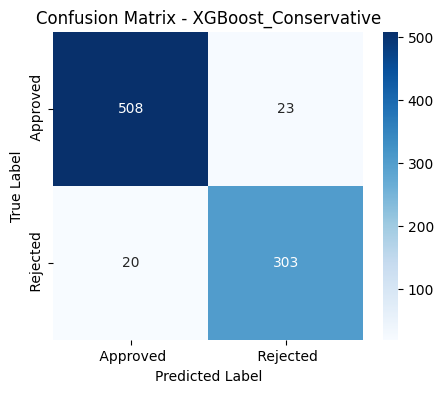


CatBoost_Conservative Detailed Results:
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

    Approved       0.99      0.92      0.95       531
    Rejected       0.88      0.98      0.93       323

    accuracy                           0.94       854
   macro avg       0.93      0.95      0.94       854
weighted avg       0.95      0.94      0.94       854


Confusion Matrix:
[[488  43]
 [  6 317]]


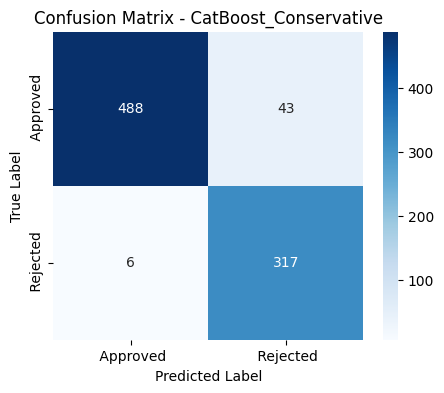

In [70]:
# Detailed evaluation for each model
for name, result in results.items():
    print(f"\n{name} Detailed Results:")
    print("-" * 40)
    
    preds = result['predictions']
    true_labels = y_test
    
    # ---- Classification Report ----
    print("Classification Report:")
    print(classification_report(
        true_labels, preds, 
        target_names=[str(cls) for cls in le_target.classes_]
    ))
    
    # ---- Confusion Matrix ----
    cm = confusion_matrix(true_labels, preds)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot Confusion Matrix (Heatmap)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", 
                xticklabels=le_target.classes_, 
                yticklabels=le_target.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()